In [1]:
import numpy as np
from sklearn.linear_model import LassoCV, ElasticNetCV, lasso_path, enet_path, OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from modopt.opt.proximity import KSupportNorm, SparseThreshold, ElasticNet
from modopt.opt.linear import Identity
from sklearn.preprocessing import normalize, MaxAbsScaler, StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.pipeline import make_pipeline
from scipy import sparse
import numpy as np
import itertools
import matplotlib.pyplot as plt
import benchopt
from benchopt.datasets.simulated import make_correlated_data
from scipy.spatial.distance import hamming
from sklearn.metrics import f1_score

In [19]:
def intersection_cardinality(vector1, vector2):
    support1 = np.nonzero(vector1)[0]
    support2 = np.nonzero(vector2)[0]
    intersection = np.intersect1d(support1, support2)
    cardinality = len(intersection)
    return cardinality

def supp_dist_metric(x, starx, k):
    return (k - intersection_cardinality(x, starx))/k

In [20]:
rs = np.random.RandomState(2)
n_features = 50
rho = 0.5
snr = 3.
X, y, x0 = make_correlated_data(n_samples=30, n_features=n_features, random_state=rs, rho=rho, snr=snr)

k = np.count_nonzero(x0)
print(k)

def test_loss(beta, X_test, y_test):
    return 1/X_test.shape[0] * np.linalg.norm(X_test @ beta - y_test)**2

10


In [36]:
def run_irksn(n_iter):
    alpha = 0.0001
    beta = np.zeros(X.shape[1])
    v = np.zeros(X.shape[0])
    z = np.zeros(X.shape[0])
    z_old = np.zeros(X.shape[0])
    nuclear_norm = np.linalg.norm(X, ord='nuc')
    gamma = alpha * nuclear_norm**(-2)
    theta = 1
    prox = KSupportNorm(beta=(1 - alpha)/alpha, k_value=k)
    losses, sparsity = [], []
    betas = []
    hammings = []
    f1s = []
    loss = []
    supp_dist_metrics= []

    
    print((2 * nuclear_norm * np.linalg.norm(np.linalg.pinv(X[:, :3].T) @ x0[:3]))/alpha)
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        hammings.append(hamming(x0.astype(bool), beta.astype(bool)))
        f1s.append(f1_score(x0.astype(bool), beta.astype(bool)))
        supp_dist_metrics.append(supp_dist_metric(beta, x0, k))
        beta = prox.op(- 1/alpha * X.T @ z)
        r = prox.op(- 1/alpha * X.T @ v)
        z_old = z + 0.
        z = v + gamma * (X @ r - y)
        theta_old = theta + 0.
        theta = (1 + np.sqrt(1 + 4 * theta ** 2))/2
        v = z + (theta_old - 1)/(theta) * (z - z_old)
    betas = np.hstack(betas)
    return sparsity, losses, betas, hammings, f1s, loss, supp_dist_metrics

In [37]:
def gradirosr(X, u, v, y):
    residual = (X @ (u * u - v * v) - y)
    return (2/X.shape[0] * X.T * u[:, None] @ (residual), -2/X.shape[0] * X.T * v[:, None] @ (residual))

def run_irosr(n_iter):
    eta = 0.1
    alpha = 0.1
    u, v = alpha * np.ones(X.shape[1]), alpha * np.zeros(X.shape[1])
    beta = u**2 - v** 2
    losses, sparsity, betas, hammings, loss, supp_dist_metrics = [], [], [], [], [], []
    f1s = []
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        hammings.append(hamming(x0.astype(bool), beta.astype(bool)))
        f1s.append(f1_score(x0.astype(bool), beta.astype(bool)))
        supp_dist_metrics.append(supp_dist_metric(beta, x0, k))

        u_grad, v_grad = gradirosr(X, u, v, y)
        u -= eta * u_grad
        v -= eta * v_grad
        beta = u**2 - v** 2
    betas = np.hstack(betas)
    return sparsity, losses, betas, hammings, f1s, loss, supp_dist_metrics

In [38]:
def shrink(u, tau, factor=1.):
    """Soft-thresholding of vector u at level tau > 0."""
    return np.sign(u) * np.maximum(0., np.abs(u) - tau)

def run_ircr(n_iter):
    beta = np.zeros(X.shape[1])
    beta_sum = beta + 0.
    beta_avg = beta + 0.
    theta = np.zeros(X.shape[0])
    theta_old = theta + 0.
    nuclear_norm = np.linalg.norm(X, ord='nuc')
    tau = 0.9 * 1/np.sqrt(2 * nuclear_norm**2)
    sigma = 0.9 * 1/np.sqrt(2 * nuclear_norm**2)
    losses, sparsity, betas, hammings, f1s, loss, supp_dist_metrics = [], [], [], [], [], [], []

    for it in range(n_iter):
        betas.append(beta_avg[:, None])
        sparsity.append(np.count_nonzero(beta_avg))
        losses.append(np.linalg.norm(x0 - beta_avg))
        hammings.append(hamming(x0.astype(bool), beta_avg.astype(bool)))
        f1s.append(f1_score(x0.astype(bool), beta_avg.astype(bool)))
        supp_dist_metrics.append(supp_dist_metric(beta, x0, k))
        
        beta = shrink(beta - tau * X.T @ (2 * theta - theta_old), tau)
        theta_old = theta + 0.
        theta = theta_old + sigma * (X @ beta - y)
        beta_sum = beta_sum + beta
        beta_avg = beta_sum / it
    betas = np.hstack(betas)
    return sparsity, losses, betas, hammings, f1s, loss, supp_dist_metrics

In [39]:
def hard_threshold(arr, k):
    top_k_indices = np.argpartition(np.abs(arr), -k)[-k:]
    thresholded_arr = np.zeros_like(arr)
    thresholded_arr[top_k_indices] = arr[top_k_indices]
    return thresholded_arr

def run_iht(n_iter):
    eta = 0.01
    beta = np.zeros(X.shape[1])
    losses, sparsity, betas, hammings, f1s, loss, supp_dist_metrics = [], [], [], [], [], [], []
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        hammings.append(hamming(x0.astype(bool), beta.astype(bool)))
        f1s.append(f1_score(x0.astype(bool), beta.astype(bool)))
        supp_dist_metrics.append(supp_dist_metric(beta, x0, k))

        beta -= eta * 1/X.shape[0] * X.T @ (X @ beta - y)
        beta = hard_threshold(beta, int(k))
    betas = np.hstack(betas)
    return sparsity, losses, betas, hammings, f1s, loss, supp_dist_metrics

In [40]:
def firosr(X, u, v, y):
    return 1/(2 * X.shape[0]) * np.sum((X @ (u * u - v * v) - y)**2)

def gradirosr(X, u, v, y):
    residual = (X @ (u * u - v * v) - y)
    return (2/X.shape[0] * X.T * u[:, None] @ (residual), -2/X.shape[0] * X.T * v[:, None] @ (residual))


def run_irosr(n_iter):
    eta = 0.001
    alpha = 1
    u, v = alpha * np.ones(X.shape[1]), alpha * np.zeros(X.shape[1])
    beta = u**2 - v** 2
    losses, sparsity, betas, hammings, f1s, loss, supp_dist_metrics = [], [], [], [], [], [], []

    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        hammings.append(hamming(x0.astype(bool), beta.astype(bool)))
        f1s.append(f1_score(x0.astype(bool), beta.astype(bool)))
        supp_dist_metrics.append(supp_dist_metric(beta, x0, k))

        u_grad, v_grad = gradirosr(X, u, v, y)
        u -= eta * u_grad
        v -= eta * v_grad
        beta = u**2 - v** 2
    betas = np.hstack(betas)
    return sparsity, losses, betas, hammings, f1s, loss, supp_dist_metrics

In [41]:
def run_srdi(n_iter):
    kappa, alpha = 0.1, 0.1
    min_val_loss = np.infty
    curr_loss = np.infty
    z = np.zeros(X.shape[1])
    beta = np.zeros(X.shape[1])
    losses, sparsity, betas, hammings, f1s, loss, supp_dist_metrics = [], [], [], [], [], [], []
    for it in range(n_iter):
        betas.append(beta[:, None])
        sparsity.append(np.count_nonzero(beta))
        losses.append(np.linalg.norm(x0 - beta))
        hammings.append(hamming(x0.astype(bool), beta.astype(bool)))
        f1s.append(f1_score(x0.astype(bool), beta.astype(bool)))
        supp_dist_metrics.append(supp_dist_metric(beta, x0, k))

        z = z + alpha/X.shape[1] * X.T @ (y - X @ beta)
        beta = kappa * shrink(z, 1)
    betas = np.hstack(betas)
    return sparsity, losses, betas, hammings, f1s, loss, supp_dist_metrics

# Plotting

In [ ]:
n_iter = 20000
sparsity_ircr, losses_ircr, betas_ircr, hammings_ircr, f1s_ircr, loss_ircr, supp_dist_metrics_ircr = run_ircr(n_iter)
sparsity_irksn, losses_irksn, betas_irksn, hammings_irksn, f1s_irksn, loss_irksn, supp_dist_metrics_irksn = run_irksn(n_iter)
sparsity_iht, losses_iht, betas_iht, hammings_iht, f1s_iht, loss_iht, supp_dist_metrics_iht = run_iht(n_iter)
sparsity_irosr, losses_irosr, betas_irosr, hammings_irosr, f1s_irosr, loss_irosr, supp_dist_metrics_irosr = run_irosr(n_iter)
sparsity_srdi, losses_srdi, betas_srdi, hammings_srdi, f1s_srdi, loss_srdi, supp_dist_metrics_srdi = run_srdi(n_iter)

Text(0, 0.5, 'F1-score')

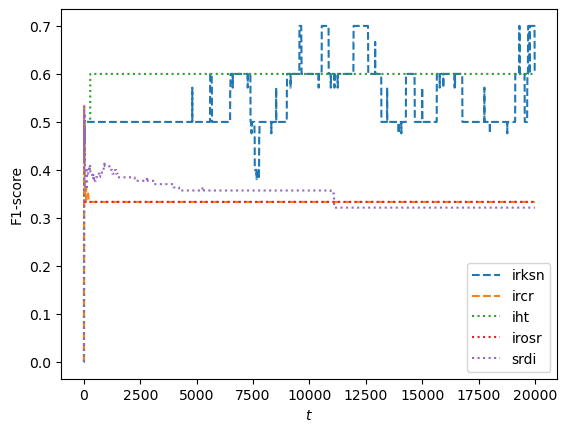

In [46]:

plt.figure()
plt.plot(f1s_irksn, label='irksn', linestyle='--')
plt.plot(f1s_ircr, label='ircr', linestyle='--')
plt.plot(f1s_iht, label='iht', linestyle=':')
plt.plot(f1s_irosr, label='irosr', linestyle=':')
plt.plot(f1s_srdi, label='srdi', linestyle=':')
plt.legend()
plt.xlabel(r'$t$')
plt.ylabel('F1-score')
